Visas bäst från https://nbviewer.jupyter.org/github/kalle-norman/Income/tree/master/<br>
Utifrån en mängd olika attributer ska vi med hjälp av olika maskininlärningsmetoder försöka avgöra sannolikheten för att en person kommer att tjäna mer eller mindre än $50 000.<br>

Här börjar jag med att importera alla nödvändiga moduler till denna uppgift. <br>
Sedan skapar jag några funktioner för att rita grafer med hjälp av Seaborn-biblioteket.<br>
Till sist skapar jag en funktion för att ansluta till SQL-databasen och läser sedan in innehållet från tabellen 'InkomstTabell' till en Pandas DataFrame.<br>

Mer info i kod-kommentarer finnes.

In [233]:
import pandas as pd     # Används för att hantera data i så kallade Dataframes
import sqlalchemy as db # sqlalchemy samt pyodbc används för att ansluta och hämta data från SQL-server
import pyodbc       
import numpy as np      # Används tillsammans med pandas för beräkningar
import random           # Används för att slumpa fram en test-post
import seaborn as sns   # Ritar upp grafer med hjälp av matplotlib
import matplotlib.pyplot as plt   

# Resterande används till de olika maskininlärningsmodeller och tekniker
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Sätter bakgrunden på graferna till vit.
sns.set(style="white") 
sns.set(style="whitegrid", color_codes=True)

# Skapar anslutningen till sql-servern för att kunna hämta tabellen med datat.
def creator():
    return pyodbc.connect(r'Driver={SQL Server};Server=DESKTOP-AO68KCB\KALLESQL;Database=TutorialDB;Trusted_Connection=yes;')

# Funktion för att rita upp en confusion matrix. In-parametrar är bland annat en lista med tillhörannde värden som True Positives och False Negatives.
def print_confusion_matrix(cm, class_names, title, figsize = (10,7)):
    df_cm = pd.DataFrame(
        [[cm[3], cm[1]], [cm[2], cm[0]]], index=class_names, columns=class_names
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap='Blues')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', )
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center', )
    heatmap.xaxis.set_label_position('top')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.title(title, fontsize=20, loc='right')
    return fig

# Ritar upp två stapeldiagram per kategorisk variabel. Den första visar frekvensen av de olika förekommande värdena
# Den andra visar hur stor andel av de olika kategoriska värdena som tjänar mer än $50k.
def bar_plt(df, x):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    plt1 = sns.countplot(x=x, data=df, ax=ax1, color='lightblue')
    plt2 = sns.barplot(x, 'income_>50K', data=df, ax=ax2, color='lightblue')
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
    ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
    plt.show()

# Ritar en ROC-kurva samt AUC-värdet för de olika modellerna
def plot_roc_curve(rocs):
    plt.figure(figsize=(12,10))
    for i in range(len(rocs)):
        plt.plot(list(rocs.values())[i][0], list(rocs.values())[i][1], 
                 label=list(rocs.keys())[i] + ', AUC: {:.3f}'.format(float(list(rocs.values())[i][2])))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
roc_list = {}
# Använder den definierade anslutningen för att hämta tabellen från SQL-databasen och sparar den i en DataFrame.
# Droppar kolumnen RowID då den inte säger någonting.
engine = db.create_engine('mssql://', creator=creator)
df = pd.read_sql_table('InkomstTabell', engine).drop('RowId', axis=1)

In [234]:
# Olika fontstorlekar till graferna
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('subplots_adjust')

<br>Nu till själva arbetet med datat.<br>Här nedan fixar jag till datatyperna för varje kolumn. Kolumner med siffror får datatypen 'int', medans de andra får 'category'.

In [235]:
# Skapar 
num_cols = ['Age', 'education num', 'capital gain', 'capital loss', 'hours per week']
df[num_cols] = df[num_cols].astype('int')
df[df.select_dtypes(include=['object']).columns] = df[df.select_dtypes(include=['object']).columns].astype('category')
df.dtypes

Age                  int32
workclass         category
education         category
education num        int32
marital status    category
occupation        category
relationship      category
race              category
sex               category
capital gain         int32
capital loss         int32
hours per week       int32
native country    category
income            category
dtype: object

<br><br>Här loopar jag först igenom de kategoriska kolumnerna och kopplar ihop de till varje unikt värde de kolumner innehåller.<br>
Då hittar man några fler underligheter markerade med röda circlar. '?', 'GALET YRKE' samt 'FEL'

In [236]:
a = {}
for col in df.select_dtypes(include=['category']):
    a.setdefault(col, df[col].unique().categories)
print(a)

{'workclass': Index(['?', 'Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay', 'Never-worked'],
      dtype='object'), 'education': Index(['HS-grad', 'Some-college', '7th-8th', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-acdm',
       'Assoc-voc', '1st-4th', '5th-6th', '12th', '9th', 'Preschool'],
      dtype='object'), 'marital status': Index(['Widowed', 'Divorced', 'Separated', 'Never-married',
       'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype='object'), 'occupation': Index(['?', 'Exec-managerial', 'Machine-op-inspct', 'Prof-specialty',
       'Other-service', 'Adm-clerical', 'Craft-repair', 'Transport-moving',
       'Handlers-cleaners', 'Sales', 'Farming-fishing', 'Tech-support',
       'Protective-serv', 'GALET YRKE', 'Armed-Forces', 'Priv-house-serv'],
      dtype='object'), 'relationship': Index(['Not-in-family', 'Unmarried', 'Own-child', 'Other-re

<br>.shape visar antalet rader och kolumner (32562 rader och 13 kolumner)
.describe är pandas 'summary' funktion. Visar antalet värden och olika mått per kolumn.
Kolumner med datatypen int visar:

-  count: Antalet icke NaN(Not a Number)-värden.
-  mean: Medelvärdet
-  std: Standardavvikelsen
-  25%, 50%, 75%: Median, samt övre- och undre kvartilen
-  max: Högsta värdet

Kategoriska värden visar:

-  count: Antalet icke NaN (Not a Number)-värden.
-  unique: Antalet unika värden
-  top: Värdet med den högsta frekvensen.
-  freq: Frekvensen av top-värdet.


In [237]:
display(df.shape)
display(df.describe())
df.describe(include='category')

(32561, 14)

,Age,education num,capital gain,capital loss,hours per week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,43.507079
std,13.640433,2.572720,7385.292085,402.960219,554.093858
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,100000.000000


,workclass,education,marital status,occupation,relationship,race,sex,native country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,16,6,5,3,43,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21789,29164,24720


Eftersom alla värden ovan har count = 32562 finns det inget NaN-värde
50 % av alla åldrar ryms mellan 28 och 48. Äldsta personen är 90 år gammal. Antalet arbetstimmar per vecka är centrerat kring 40-45 timmar. Dock kan vi utläsa ett felaktigt värde då det är omöjligt att arbeta 100 000 timmar under en vecka.
Vidare ser vi att de allra flesta, minst 75 %, varken har någon kapitalinkomst eller förlust.

För de kategoriska värdena kan vi se att de flesta jobbar i den privata sektorn. Ca 75% av alla tjänar mindre än $50k.
<br>
<br>
<br>

Här skapar jag en ny DataFrame med frekvensen av de felaktiga orden/tecknet i kolumnnamnen.
Då ser vi att 'GALET YRKE' samt 'FEL' endast förekommer en gång, medan '?' förekommer betydligt fler.
Under tabellen, markerat med en cirkel, ser vi att det högsta antalet okända/felaktiga värden per rad är tre av 14 kolumner, vilket jag inte anser är tillräckligt för att behöva ta bort hela raden.

In [238]:
df_c = pd.DataFrame({'columns': list(df)}) 
df_c['?'] = df.isin(['?']).sum(axis=0).reset_index(drop=True)
df_c['GALET YRKE'] = df.isin(['GALET YRKE']).sum(axis=0).reset_index(drop=True)
df_c['FEL'] = df.isin(['FEL']).sum(axis=0).reset_index(drop=True)
df_c['? %'] = df_c['?'] / len(df)
display(df_c)

# Summerar radvis hur många felaktiga värden som finns per rad samt hittar det högsta antalet felaktiga värden(3)
df.isin(['?', 'GALET YRKE', 'FEL']).sum(axis=1).max()

,columns,?,GALET YRKE,FEL,? %
0,Age,0,0,0,0.000000
1,workclass,1836,0,0,0.056386
2,education,0,0,0,0.000000
3,education num,0,0,0,0.000000
4,marital status,0,0,0,0.000000
5,occupation,1842,1,0,0.056571
6,relationship,0,0,0,0.000000
7,race,0,0,0,0.000000
8,sex,0,0,1,0.000000
9,capital gain,0,0,0,0.000000


3

Här ersätter jag de felaktiga värdena med 'Unknown', då det är okänt. <br>
Därefter skapar jag dummy-kolumner av både income samt kön-kolumnen, dvs skapar en kolumn med själva värdet av featuren, som kodas till 1 eller 0. Om värdet för variabeln finns i raden får kolumnen för sagda värde en 1:a. Annars 0. Detta för att underlätta för maskininlärningsmodellerna senare samt hur varje kategori relaterar till inkomsten som visas i diagram senare. Sedan ersätter jag det felaktiga värdet, 100000, i 'hours per week'-kolumnen med medianen, dvs 40.<br>
Sen sätter jag ihop kaipitalintäkter/förlust till en kolumn där förluster får ett negativt värde.

Vidare skapar jag en testpost som slumpar fram värden utifrån de som finns i varje kolumn och lägger in den som sista rad i DataFramenför att testas senare.

Sen buntar jag ihop alla övriga länder än USA till 'Other'. (Det kanske hade varit bättre att gruppera efter världsdel men valde den enklare vägen.)
Till sist lägger jag ihop alla värden med en kortare studeringstid än 12 år till '12_years_or_less', då frekvensen för de olika variablerna var väldigt låg, samt att de alla hade väldigt lika förhållande till hur stor andel som tjänar mindre än $50000, ca 95 %

In [239]:
df = df.replace(['?', 'GALET YRKE', 'FEL'], 'Unknown')        # Ersätter felaktiga värden
df = pd.get_dummies(df, columns=['income'])
df = pd.get_dummies(df, columns=['sex']).drop(['sex_Male', 'sex_Unknown'], axis=1)
df['hours per week'] = df['hours per week'].replace(100000, np.median(df['hours per week'].astype(int)))
print(df.dtypes)
df[df.select_dtypes(include=['object']).columns] = df[df.select_dtypes(include=['object']).columns].astype('category')
df['capital gain/loss'] = df['capital gain'] - df['capital loss']
df = df.drop(['capital gain', 'capital loss'], axis=1)

test_post = []
for i in df.columns:
    test_post.append(random.choice(df[i].value_counts().index))
print(test_post)
tmp = dict(zip(df.columns, test_post))
temp = pd.DataFrame.from_dict(data=tmp, orient='index')
temp = temp.T
df = pd.concat([df, temp], ignore_index=True)

num_cols = ['Age', 'capital gain/loss', 'hours per week', 'income_<=50K', 'income_>50K', 'sex_Female', 'education num']
df[num_cols] = df[num_cols].astype(int)
df[df.select_dtypes(include=['object']).columns] = df[df.select_dtypes(include=['object']).columns].astype('category')
df.dtypes
df['native country'] = np.where(df['native country'] == 'United-States', 'United-States', 'Other')
df['education'] = np.where((df['education'].str[0].str.isnumeric() == True) | (df['education'] == 'Preschool'), '12_Years_or_less', df['education'])

Age                int64
workclass         object
education         object
education num      int64
marital status    object
occupation        object
relationship      object
race              object
capital gain       int64
capital loss       int64
hours per week     int64
native country    object
income_<=50K       uint8
income_>50K        uint8
sex_Female         uint8
dtype: object
[38, 'Self-emp-inc', 'Prof-school', 6, 'Married-AF-spouse', 'Exec-managerial', 'Own-child', 'White', 72, 'Ecuador', 1, 1, 1, 2964]


Här har vi ett lådagram och ett histogram som visar fördelningen på åldrarna i datasetet. Då kan vi se att den har en positiv skevhet. 

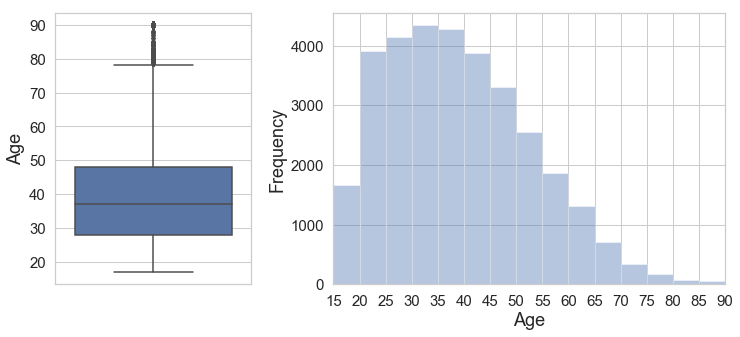

In [241]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={'width_ratios': [1, 2]})
plt.subplots_adjust(wspace=0.28)
plt1 = sns.boxplot(y='Age', data=df, ax=ax1)
plt2 = sns.distplot(df.Age, bins=range(15,91,5), ax=ax2, kde=False)
ax2.set_xlim(17,90)
ax2.set_xticks(range(15,91,5))
ax2.set(ylabel=('Frequency'))
plt.show()

Nedan visas åldersfördelningen på de som tjänar mer samt mindre än $50000. Då kan vi utläsa att gruppen som tjänar mer har ett högre åldersmedelvärde, vilket betyder att det är en större sannolikhet att man tjänar mer ju äldre man är. Vilket inte är så konstigt.

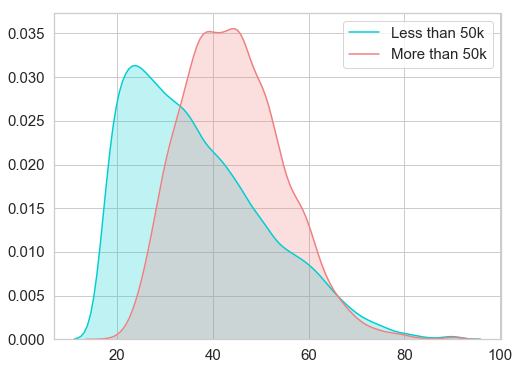

In [242]:
plt.figure(figsize=(8,6))
sns.kdeplot(df['Age'][df['income_>50K'] == 0], label='Less than 50k', color='darkturquoise', shade=True)
sns.kdeplot(df['Age'][df['income_>50K'] == 1], label='More than 50k', color='lightcoral', shade=True)
plt.show()

Ett stort antal, ca 50 % jobbar mellan 40 och 45 timmar i veckan.

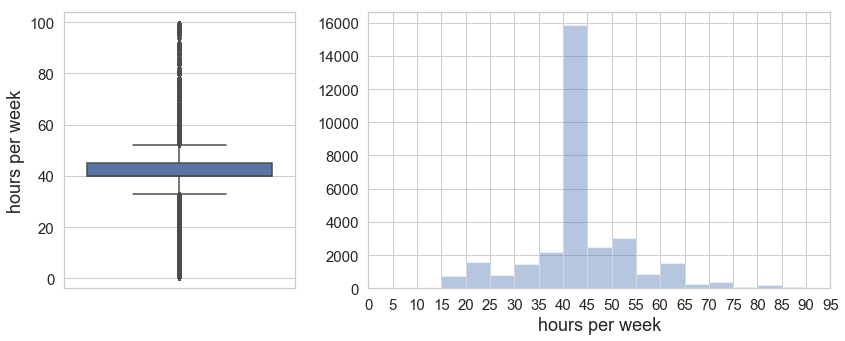

In [243]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={'width_ratios': [1, 2]})
plt1 = sns.boxplot(y='hours per week', data=df, ax=ax1)
plt2 = sns.distplot(df['hours per week'], bins=range(15,91,5), ax=ax2, kde=False)
ax2.set_xlim(0,90)
ax2.set_xticks(range(0,100,5))
plt.tight_layout()

Här följer två stapeldiagram för varje av de kategoriska kolumnerna. Det första visar frekvensen av varje värde och den andra visar hur stor del av de som tjänar mer än $50000. 

De allra flesta jobbar i den privata sektorn medan den som har högst andel som tjänar mer är egenföretagare. I civilståndskategorin ser vi att gifta människor har en mycket högre sannolikhet att tjäna mera, då ca 45 % tjänar mer än $50000 till skillnad mot 10 % för de andra i kategorin.

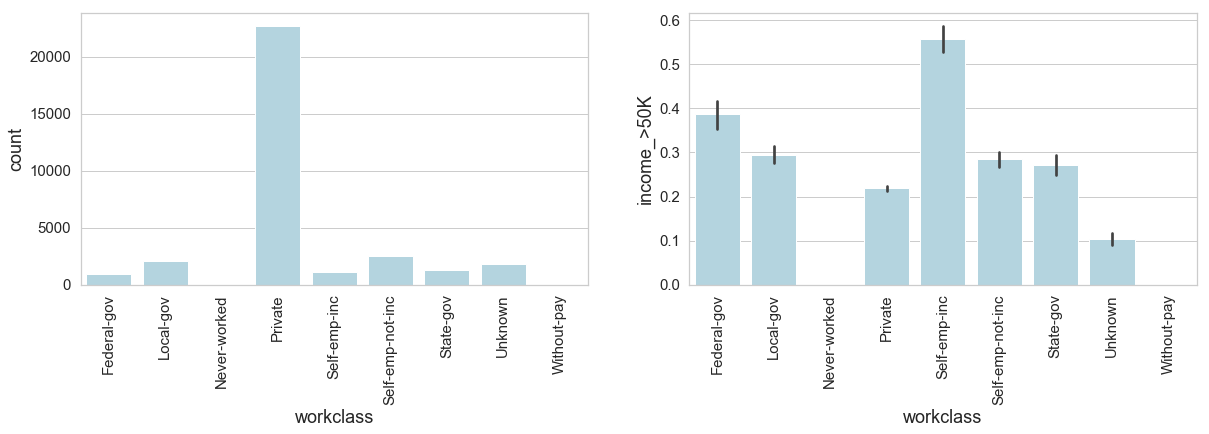

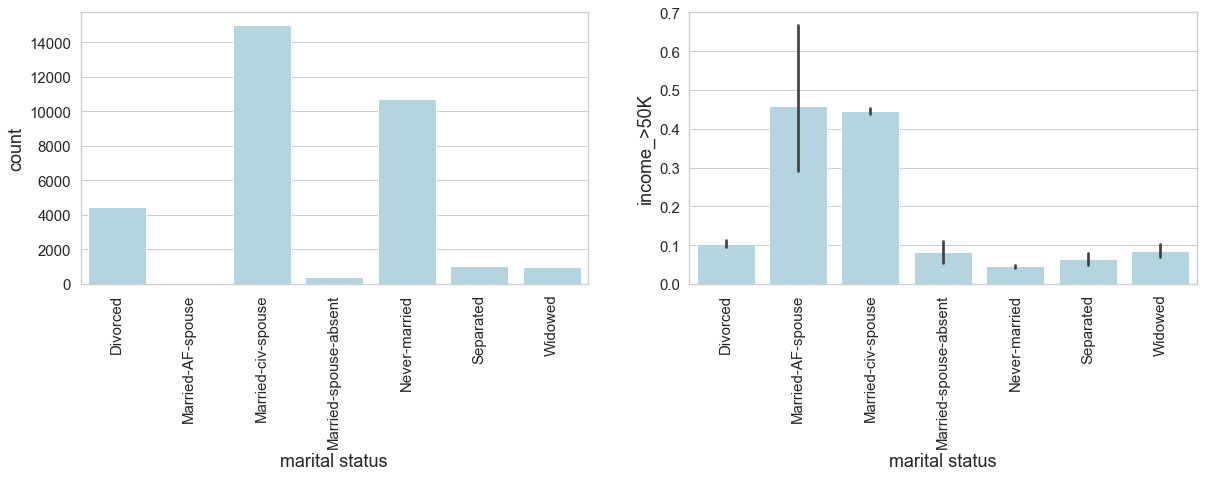

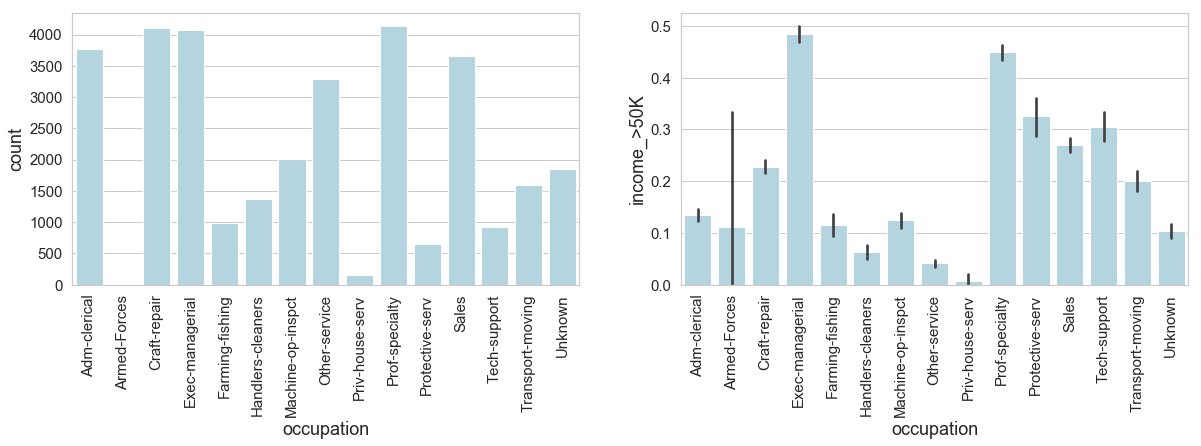

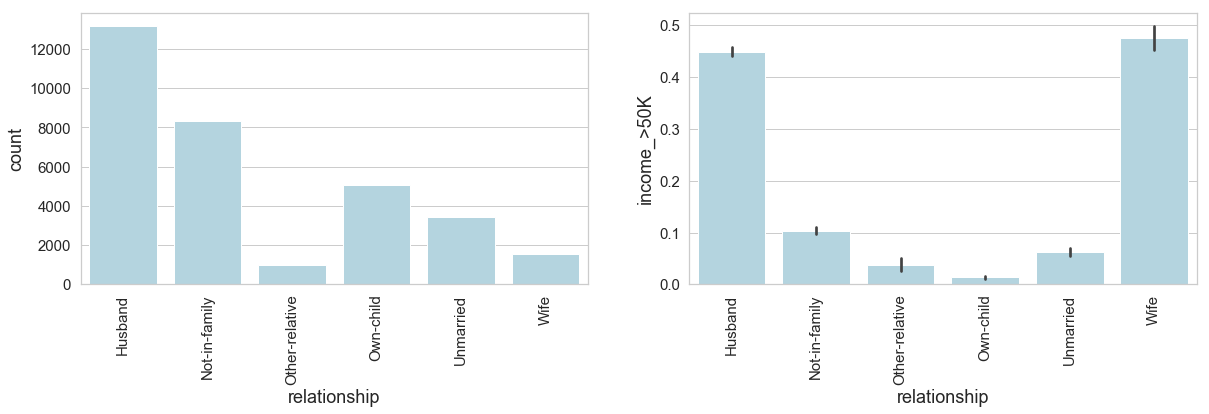

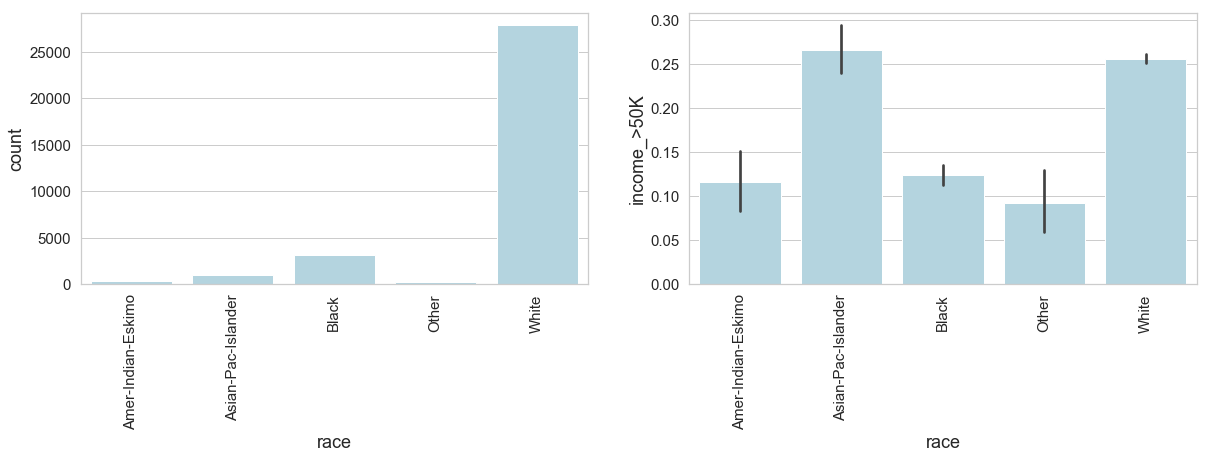

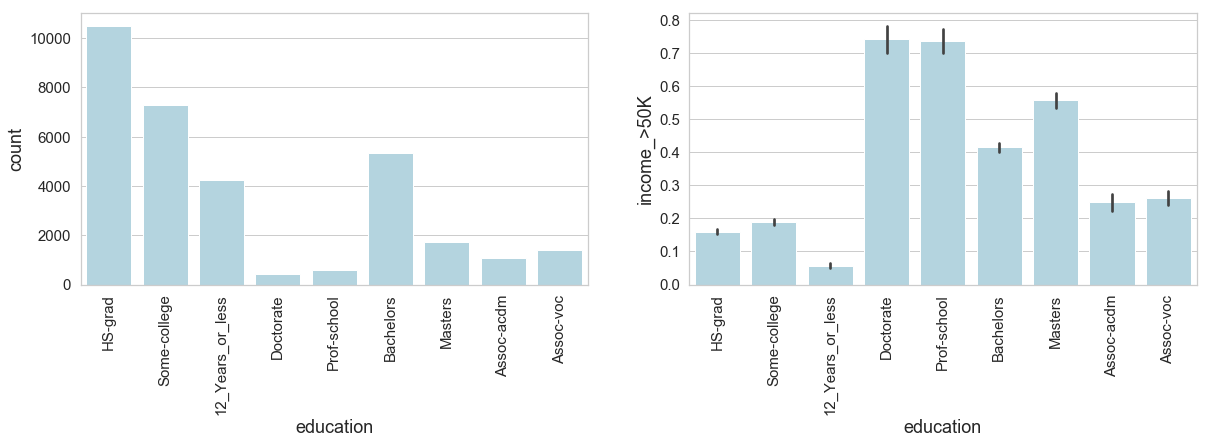

In [244]:
for col in df.select_dtypes(include=['category']):
    #if col == 'native country':
       # break
    bar_plt(df, col)
bar_plt(df, 'education')

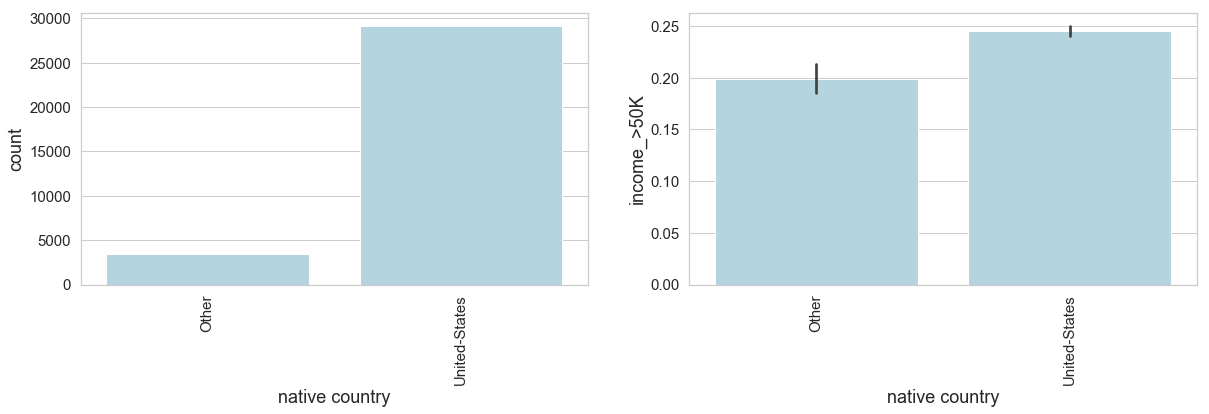

In [245]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
plt1 = sns.countplot(x='native country', data=df, ax=ax1, color='lightblue')
plt2 = sns.barplot('native country', 'income_>50K', data=df, ax=ax2, color='lightblue')
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
plt.show()

<br>
Här kan se hur de olika siffer-kolumnerna korrelerar med varandra. Då syns det att störst korrelation finns mellan de som tjänar mer och de som har studerat längre. Även kön, arbetstimmar samt ålder har en liknande hög korrelation med inkomsten

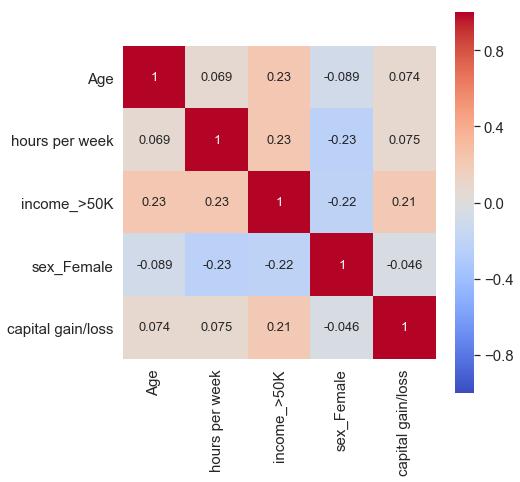

In [389]:
plt.subplots(figsize=(7,7))
sns.heatmap(df.drop('income_<=50K', axis=1).corr(), square=True, cmap='coolwarm', annot=True, annot_kws={"size": 13}, vmin=-1)
plt.show()

<br><br>
Här förbereds datasetet till de olika maskininlärningsmodellerna. Här väljer jag att ta bort education num-kolumnen, eftersom den finns som kategorisk kolumn och det riskerar att få ett för högt vikt-värde i modellerna. Därefter får alla variabler en egen kolumn med värdet 1 eller 0 (True/False), beroende på om variabeln finnes i raden. Därefter tar jag bort de kolumner som har mindre än 60 st ettor, då det är för få för att få ut någonting meningsfullt från dem. Sedan plockar jag ut sista raden som är en test post och sparar den till test_post_pred. Sparar resterande rader till en x och y variabel. I 'x' sparas alla kolumner förutom själva kolumnen som skall förutses, medan y enbart får den, alltså 'income_<=50K', där en etta innebär att personen tjänar mindre än 50k. 

In [246]:
df = df.drop('education num', axis=1)
temp = pd.get_dummies(df, drop_first=True)
col_list = []
for col in list(temp)[6:]:
    if (len(temp[temp[col] == 1])) < 60:
        col_list.append(col)
    if col.endswith('Unknown'):
        col_list.append(col)
temp = temp.drop(col_list, axis=1)
test_post_pred = pd.DataFrame(temp.iloc[-1])
test_post_pred = test_post_pred.T.drop(['income_<=50K', 'income_>50K'], axis=1)
x = temp.drop(['income_<=50K', 'income_>50K'], axis=1).iloc[0:-1,:]
y = temp['income_<=50K'].iloc[0:-1]


<br><br>Här börjar jag först med att dela upp x och y till en träningsdel och en testdel med hjälp av train_test_split-funktionen. Detta för att kunna validera modellen och se att den inte overfittas till att enbart fungera på träningsdatat. Testdelen är 30 % av hela datasetet och träningsdelen 70 %. Modellen tränas sedan genom .fit funktionen. Vidare testas modellen där varje rad får en viss sannolikhet för att den personen tjänar mindre än 50k. Sedan avrundas det till antingen 1 eller 0. Detta jämförs sedan med de faktiska värdena för att då kunna få fram antalet true positives, false positives, false negatives samt true negatives, som sedan ställs upp i en confusion matrix. Använder sen olika funktioner för att utvärdera modellen. Tar med accuracy på både träningsdata samt testdata för att se att modellen inte overfittas för mycket. Det skulle visa sig genom att den är jättebra på att avgöra utfallan på träningsdelen samtidigt som den skulle vara mycket sämre på testdelen. 
För Gradient Booster och Random Forest-modellerna tar jag även fram de viktigaste featuresena för att visa de i ett diagram senare. Sedan visas den slumpade testposten och sannolikheten att den personen skulle tjäna mindre än $50k. (Dock kan man få fram lite intressanta kombinationer som exempelvis en ålder på 17 och redan tagit en master och hunnit skilja sig!)

Till sist printas en Confusion matrix ut med true positives upp till vänster. Detta upprepas för varje modell

,Age,workclass,education,marital status,occupation,relationship,race,hours per week,native country,sex_Female,capital gain/loss
32561,38,Self-emp-inc,Prof-school,Married-AF-spouse,Exec-managerial,Own-child,White,72,Other,1,2964


'Has a 60.76 % chance of earning less than $50k according to the Logistic Regression model'

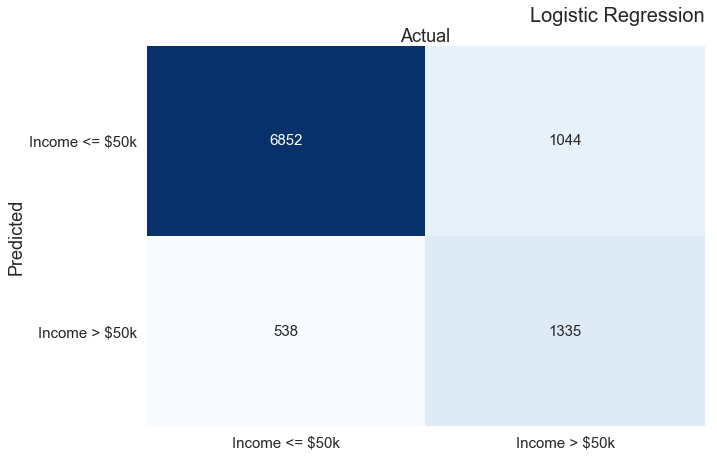

In [364]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)     # Split funktion
df_data = []                                                        # Lista för att spara olika mätvärden till modellen
ml_model = 'Logistic Regression'                                    # Namn på modellen som används
logreg = LogisticRegression(max_iter=100)                           # Definierar modellen som sall användas
logreg.fit(x_train,y_train)                                         # Tränar modellen
log_probs = logreg.predict_proba(x_test)[:,1]                       # Testar modellen - sannolikhetsutfall för att personen tjänar <=50K
y_pred_log = logreg.predict(x_test)                                 # Samma, fast avrundar värdet till 0 eller 1. Detta används senare till att jämföra med de faktiska värdena

# Sparar mätvärden till en lista
df_data.append(logreg.score(x_train, y_train))
df_data.append(logreg.score(x_test, y_test))
df_data.append(metrics.precision_score(y_test, y_pred_log))
df_data.append(metrics.recall_score(y_test, y_pred_log))
df_data.append(metrics.f1_score(y_test, y_pred_log))
auc_log = metrics.roc_auc_score(y_test, log_probs)

fpr, tpr, thresholds = metrics.roc_curve(y_test, log_probs)
roc_list.setdefault(ml_model, [fpr, tpr, auc_log])
print_confusion_matrix(metrics.confusion_matrix(y_test, y_pred_log).ravel(), ['Income <= $50k', 'Income > $50k'], ml_model);

# Visar testposten samt sannolikheten att personen tjänar mindre än $50k
display(df.drop(['income_>50K', 'income_<=50K'], axis=1).tail(1), f'Has a {(logreg.predict_proba(test_post_pred)[0][1]*100):.2f} % chance of earning less than $50k according to the {ml_model} model')
print('\n')

# Skapar en DataFrame med de olika måtten
df_scores = pd.DataFrame(data=df_data, columns=['Logistic Regression'], index=['Accuracy train', 'Accuracy test', 'Precision', 'Recall', 'F1'])

,Age,workclass,education,marital status,occupation,relationship,race,hours per week,native country,sex_Female,capital gain/loss
32561,38,Self-emp-inc,Prof-school,Married-AF-spouse,Exec-managerial,Own-child,White,72,Other,1,2964


'Has a 77.30 % chance of earning less than $50k according to the Gradient Booster model'

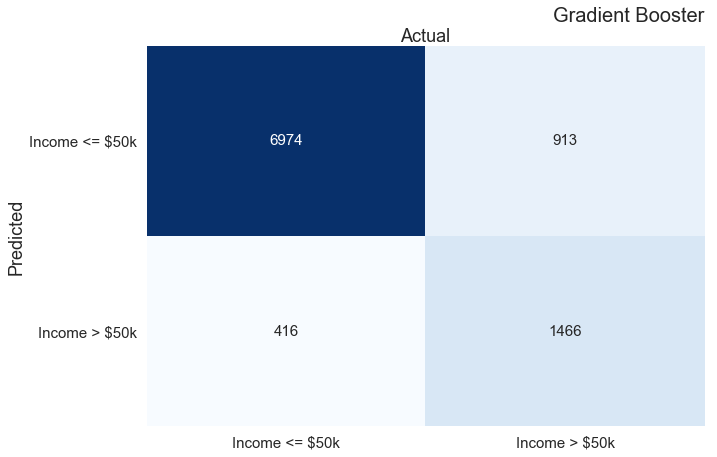

In [385]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)
df_data = []
ml_model = 'Gradient Booster'
gb_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.32, max_features=10, max_depth=4, random_state=0)
gb_clf.fit(x_train, y_train)
probs = gb_clf.predict_proba(x_test)
probs = probs[:,1]
y_pred_gb = gb_clf.predict(x_test)
feat_importance_gb = pd.DataFrame(index=list(x_train), data=gb_clf.feature_importances_, columns=[ml_model]).reset_index().sort_values(by=ml_model, ascending=False).head(10)
df_data.append(gb_clf.score(x_train, y_train))
df_data.append(gb_clf.score(x_test, y_test))
df_data.append(metrics.precision_score(y_test, y_pred_gb))
df_data.append(metrics.recall_score(y_test, y_pred_gb))
df_data.append(metrics.f1_score(y_test, y_pred_gb))

auc_gb = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
roc_list.setdefault(ml_model, [fpr, tpr, auc_gb])
print_confusion_matrix(metrics.confusion_matrix(y_test, y_pred_gb).ravel(), ['Income <= $50k', 'Income > $50k'], ml_model);

print('\n')
display(df.drop(['income_>50K', 'income_<=50K'], axis=1).tail(1), f'Has a {(gb_clf.predict_proba(test_post_pred)[0][1]*100):.2f} % chance of earning less than $50k according to the {ml_model} model')
df_scores[ml_model] = df_data
print('\n')


,Age,workclass,education,marital status,occupation,relationship,race,hours per week,native country,sex_Female,capital gain/loss
32561,38,Self-emp-inc,Prof-school,Married-AF-spouse,Exec-managerial,Own-child,White,72,Other,1,2964


Has a 73.56 % chance of earning less than $50k according to the Random Forest model




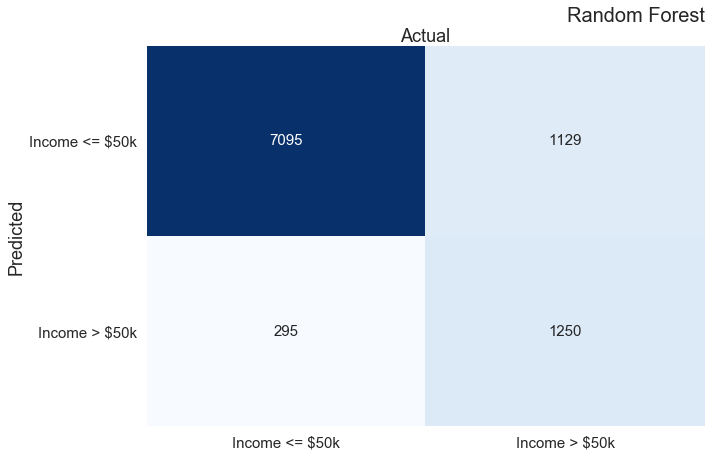

In [386]:
df_data = []
ml_model = 'Random Forest'
random_forest = RandomForestClassifier(n_estimators=80, max_depth=9, random_state=0)
random_forest.fit(x_train, y_train)
m = random_forest.score(x_test, y_test)
y_pred_rf = random_forest.predict(x_test)
probs = random_forest.predict_proba(x_test)
probs = probs[:,1]
df_data.append(random_forest.score(x_train, y_train))
df_data.append(random_forest.score(x_test, y_test))
df_data.append(metrics.precision_score(y_test, y_pred_rf))
df_data.append(metrics.recall_score(y_test, y_pred_rf))
df_data.append(metrics.f1_score(y_test, y_pred_rf))
auc_rf = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
roc_list.setdefault('Random Forest', [fpr, tpr, auc_rf])
print_confusion_matrix(metrics.confusion_matrix(y_test, y_pred_rf).ravel(), ['Income <= $50k', 'Income > $50k'], ml_model);
feat_importance_rf = pd.DataFrame(index=list(x_train), data=random_forest.feature_importances_, 
                                  columns=[ml_model]).reset_index().sort_values(by=ml_model, ascending=False).head(10)

display(df.drop(['income_>50K', 'income_<=50K'], axis=1).tail(1))
print(f'Has a {(random_forest.predict_proba(test_post_pred)[0][1]*100):.2f} % chance of earning less than $50k according to the {ml_model} model')
print('\n')
df_scores[ml_model] = df_data

<br><br>Här ser vi Roc-kurvor samt AUC för de olika modellerna och där kan vi urskilja att Gradient Booster har högst AUC

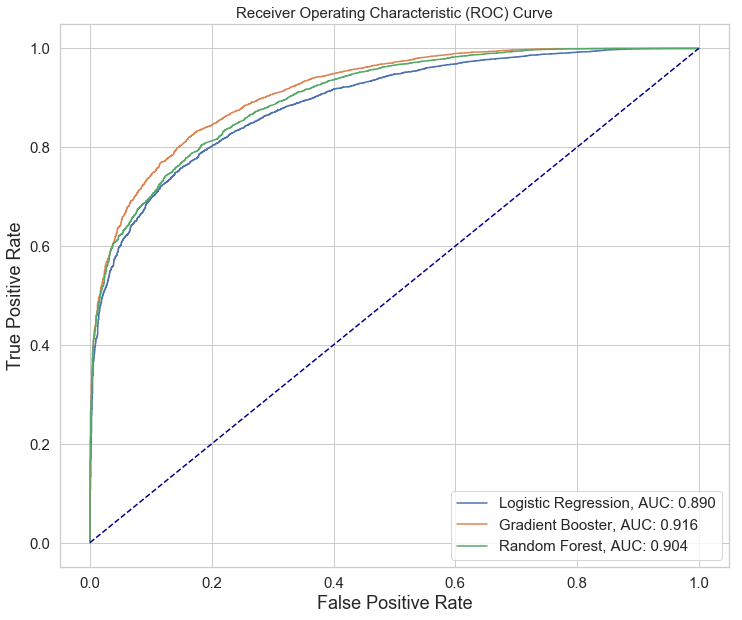

In [94]:
plot_roc_curve(roc_list)

<br><br>Här har vi olika mätvärden för de olika modellerna. Högst accuracy har Gradient Booster-modellen och lägst har Logistic Regression. Random Forest har dock en högre Recall rate.

In [388]:
display(df_scores)

,Logistic Regression,Gradient Booster,Random Forest
Accuracy train,0.845999,0.880046,0.865611
Accuracy test,0.838059,0.863957,0.854233
Precision,0.867781,0.884240,0.862719
Recall,0.927199,0.943708,0.960081
F1,0.896507,0.913006,0.908800


<br><br>Här visas de två bästa modellerna och de 10 viktigaste featuresen för Gradient Booster samt Random Forest. De skiljer sig något men är väldigt lika ändå. Kapitalinkomster och att vara gift verkar ha störst betydelse.

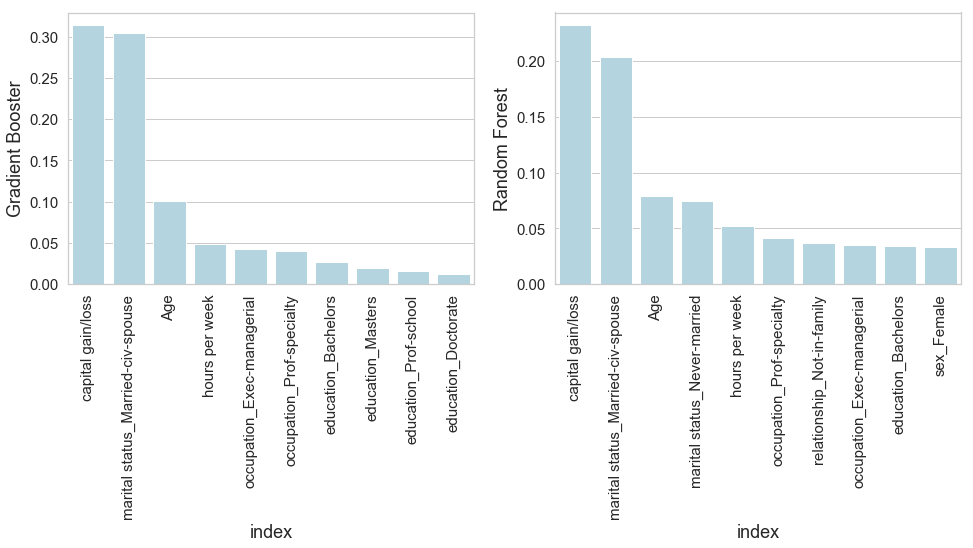

In [363]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)

plt1 = sns.barplot(x='index', y='Gradient Booster', data=feat_importance_gb, ax=ax1, color='lightblue')
plt2 = sns.barplot(x='index', y='Random Forest', data=feat_importance_rf, ax=ax2, color='lightblue')


Då uppgiften handlade om att skapa en så bra modell som möjligt för att kunna avgöra om en person skulle tjäna mer än $50k så är det gärna accuracyn vi vill ha så hög som möjligt, vilket då är andelen rätt modellen haft.

Eftersom det inte finns någon extra kostnad för att exempelvis ha en högre andel false negatives än false positives såå spelar inte recall rate ingen roll. Hade det gjort det hade man fått överväga om Random Forest-modellen skulle ha använts istället för Gradient Booster, som fick högst träffäkerhet! Kapitalinkomster, civilstånd och ålder är betydande faktorer till resultatet. <br>
Avslutningsvis vill jag säga att denna uppgift har varit riktigt rolig och intressant. Valde att göra allt i Python då jag vill bli mer och mer van och bekväm med det. Stundtals var det väldigt krångligt men det känns nu som jag har fått en mycket bättre uppfattning till hur man går till väga med maskinlärning. Inser att vi bara skrapat lite på ytan kring hela ämnet men jag ser verkligen fram emot nästa kurs som fortsätter på samma ämne.